In [9]:
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
import qhchina

qhchina.load_fonts()

def visualize_attention_CLS(model, tokenizer, couplet, labels=None, filename=None):
    model.eval()
    sequence_length = (2 * 5) + 3
    encoding = tokenizer(couplet[0] + "，" + couplet[1], 
                         add_special_tokens=True,
                         max_length=sequence_length, 
                         padding='max_length', 
                         truncation=True,
                         return_tensors='pt')

    input_ids = encoding['input_ids'].to(model.device)
    attention_mask = encoding['attention_mask'].to(model.device)

    sequence = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
    print(sequence)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, 
                        attention_mask=attention_mask, 
                        output_hidden_states=True, 
                        output_attentions=True)

    last_layer_attention = outputs.attentions[-1]  # Shape: (1, num_heads, seq_length, seq_length)
    num_heads = last_layer_attention.shape[1]
    attention_CLS_all = []

    for head in range(num_heads):
        attention_matrix = last_layer_attention[0, head].cpu().numpy()
        attention_CLS = attention_matrix[0, :]
        attention_CLS_all.append(attention_CLS)

    attention_CLS_all = np.array(attention_CLS_all)
    # Plot a grid of heatmaps (one for each head)
    fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and an axes object
    if labels is not None:
      sequence[1:6] = [char for char in labels[0]]
      sequence[7:12] = [char for char in labels[1]]
    vmax = np.max(attention_CLS_all)
    print(vmax)
    vmax = 0.5
    sns.heatmap(attention_CLS_all, cmap="viridis", vmin=0, vmax=vmax, cbar=True, xticklabels=sequence, yticklabels=["Head " + str(head+1) for head in range(12)], ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  # Set y-tick labels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    if filename is not None:
      plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

In [ ]:
# Loading the fine-tuned model instead of training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
tokenizer = BertTokenizer.from_pretrained('qhchina/SikuBERT-parallelism-wuyan-0.1')
model = BertForSequenceClassification.from_pretrained('qhchina/SikuBERT-parallelism-wuyan-0.1', attn_implementation="eager").to(device)

cpu


['[CLS]', '明', '月', '松', '间', '照', '，', '清', '泉', '石', '上', '流', '[SEP]']
0.48091352


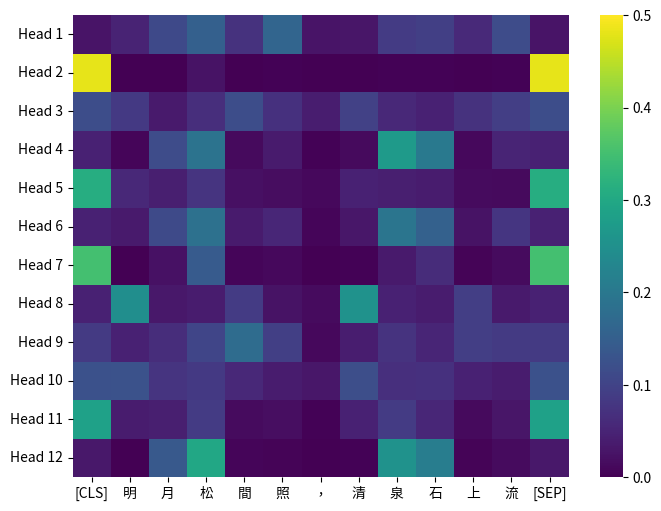

In [ ]:
parallel_couplet = ("明月松间照","清泉石上流")
visualize_attention_CLS(model, tokenizer, parallel_couplet, labels=("明月松間照","清泉石上流"))

['[CLS]', '空', '山', '新', '雨', '后', '，', '天', '气', '晚', '来', '秋', '[SEP]']
0.38419604


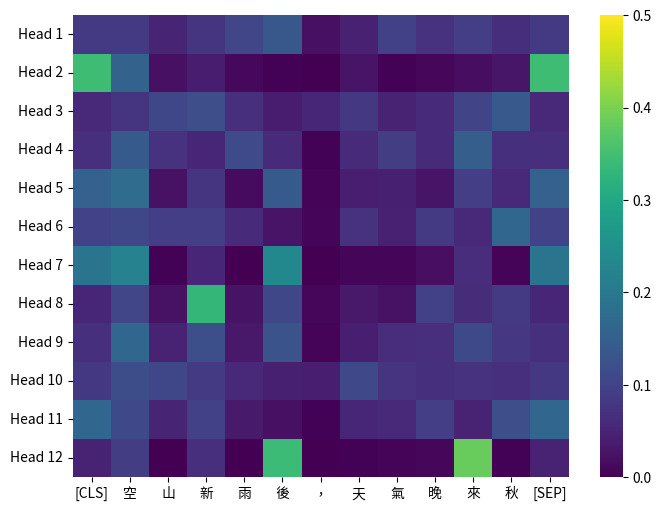

In [ ]:
non_parallel_couplet = ("空山新雨后","天气晚来秋")
visualize_attention_CLS(model, tokenizer, non_parallel_couplet, labels=("空山新雨後","天氣晚來秋"))